In [1]:
import pandas as pd
from pathlib import Path
from athletes_brain.config import EXTERNAL_DATA_DIR

sessions = pd.read_csv("~/Projects/plasticityhub/sessions.csv")
sessions = sessions.sort_values(["subject_code", "session_id"])
sessions["session_id"] = sessions["session_id"].astype(str).str.zfill(12)
sessions["subject_code"] = sessions["subject_code"].apply(
    lambda x: x.replace("-", "")
    .replace("_", "")
    .replace(" ", "")
    .replace("\t", "")
    .replace("\n", "")
    .replace("MֹC", "MC")
)
sessions = sessions[sessions["subject_code"] != "0000"]
# sessions["exercise_frequency"] = sessions["exercise_frequency"].replace(
#     {"": pd.NA, "1-2": 1.5, "3-4": 3.5, "5+": 5}
#     ).astype(float)
# drop duplicated indices
# d = d[~d.index.duplicated(keep="first")]
sessions["timestamp"] = pd.to_datetime(sessions["session_id"], format="%Y%m%d%H%M%S")

2025-09-07 17:57:24.508 | INFO     | athletes_brain.config:<module>:11 - PROJ_ROOT path is: /home/galkepler/Projects/athletes_brain


In [14]:
s = sessions[(~sessions["condition"].str.lower().isin(["learning","novice control"])) & (sessions["group"].str.lower().isin(["bjj","climbing"]))]
repeated = s[s.duplicated(subset=["subject_code"], keep=False)].copy()
# repeated["condition"].unique()
repeated.drop_duplicates(subset="subject_code",keep="first")["group"].value_counts()

group
Climbing    76
Bjj         36
Name: count, dtype: int64

In [24]:
assessment_df = pd.read_csv(EXTERNAL_DATA_DIR / "skill_assessment_new.csv")
assessment_df = assessment_df.rename(
    columns={
        "Participant": "subject_code",
        "Session Score": "score",
        "Session Timestamp": "timestamp",
        "Climbing Gym": "gym",
        "Timestamp": "timestamp",
    }
)
assessment_df["subject_code"] = (
    assessment_df["subject_code"]
    .apply(
        lambda x: x.replace("-", "")
        .replace("_", "")
        .replace(" ", "")
        .replace("\t", "")
        .replace("\n", "")
    )
    .str.zfill(4)
)

assessment_df["timestamp"] = pd.to_datetime(assessment_df["timestamp"], errors="coerce")

In [25]:
assessment_df

,subject_code,timestamp,gym,score
0,CLMC4,2025-07-23 12:08:12,הבלוק,24.90
1,0374,2022-03-24 12:56:59,פרפורמנס רוק תא,43.21
2,0386,2025-08-07 20:39:25,פרפורמנס רוק תא,18.60
3,0401,2022-06-02 11:01:16,פרפורמנס רוק תא,15.47
4,0401,2025-09-04 20:53:56,פרפורמנס רוק תא,12.67
...,...,...,...,...
393,CLMP7,2024-08-23 11:41:13,קמפוס,29.25
394,CLMP7,2024-11-22 11:15:46,קמפוס,45.78
395,CLMP8,2024-09-17 17:01:56,"אייזק ת""א",70.72
396,CLMP9,2024-12-23 21:47:20,"ונגה פ""ת",32.15


In [22]:
climbers = sessions[(sessions["group"] == "Climbing") & (sessions["condition"] != "Learning")]
qa_df = pd.DataFrame(
    columns=["subject_code", "subject_id", "n_scanning_sessions", "n_assessment_sessions"]
)
for subject_code, group in climbers.groupby("subject_code"):
    n_scanning_sessions = group.shape[0]
    n_assessment_sessions = assessment_df[assessment_df["subject_code"] == subject_code].shape[0]
    subject_id = str(group["subject_id"].iloc[0]).zfill(9)
    qa_df.loc[len(qa_df)] = [subject_code, subject_id, n_scanning_sessions, n_assessment_sessions]

In [23]:
print(f"Number of climbers: {len(qa_df)}")
qa_df.to_csv("/home/galkepler/Downloads/control_climbers_to_contact.csv", index=False)
# qa_d

Number of climbers: 90


In [26]:
df = pd.DataFrame(
    columns=sessions.columns.tolist()
    + ["assessment_timestamp", "assessment_gym", "assessment_score"]
)

ind = 0

for i, row in assessment_df.iterrows():
    subject = row["subject_code"]
    session = row["timestamp"]
    if subject not in sessions["subject_code"].values:
        print(f"Subject {subject} not found in sessions.")
        continue
    subject_data = sessions.loc[sessions["subject_code"] == subject]
    # find the closest session to the assessment timestamp
    closest_session = subject_data.iloc[(subject_data["timestamp"] - session).abs().argsort()[:1]]
    if closest_session.empty:
        print(f"No sessions found for subject {subject} at {session}.")
        continue
    closest_session = closest_session.iloc[0]
    for col in df.columns:
        if col in closest_session:
            df.at[ind, col] = closest_session[col]
    df.at[ind, "assessment_timestamp"] = row["timestamp"]
    df.at[ind, "assessment_gym"] = row["gym"]
    df.at[ind, "assessment_score"] = row["score"]
    ind += 1

df["study"] = "Sport"
df["group"] = "Climbing"
df = df.rename(columns={"session_id": "scanning_session_id", "timestamp": "scanning_timestamp"})

In [27]:
# keep only participants with more than one session
df_repeated = df[
    df["subject_code"].isin(
        df["subject_code"].value_counts()[df["subject_code"].value_counts() > 1].index
    )
]

In [28]:
df_repeated.to_csv(EXTERNAL_DATA_DIR / "sessions_climbing.csv", index=False)

In [29]:
# Tag session numbers (1, 2, 3, ...) for each subject
df["session_number"] = df.groupby("subject_code").cumcount() + 1

# df.drop_duplicates(subset="subject_code",keep="first").groupby(["condition"]).count()
# df_repeated.drop_duplicates(subset="subject_code", keep="first")
# df["subject_code"].value_counts()
df_repeated.drop(
    columns=["scanning_timestamp", "path", "study", "group", "scanning_session_id", "subject_id"]
).to_csv(EXTERNAL_DATA_DIR / "climbing_sessions.csv", index=False)

In [30]:
df_repeated[df_repeated["subject_code"] == "0618"]

,subject_code,subject_id,dob,age_at_scan,sex,scanning_session_id,study,group,condition,path,...,screen_time,situational_phobia,social_phobia,animal_based_phobia,medical_phobia,total_phobia,scanning_timestamp,assessment_timestamp,assessment_gym,assessment_score
42,0618,36385151,1979-02-15,42.98,M,202202061629,Sport,Climbing,Learning,/mnt/62/Raw_Data/20220206_1629,...,3.0,0.0,0.0,0.0,0.0,0.0,2022-02-06 16:02:09,2022-02-10 21:17:55,פרפורמנס רוק תא,4.42
43,0618,36385151,1979-02-15,43.06,M,202203071404,Sport,Climbing,Learning,/mnt/62/Raw_Data/20220307_1404,...,3.0,0.0,0.0,0.0,0.0,0.0,2022-03-07 14:00:04,2022-03-14 21:43:21,פרפורמנס רוק תא,3.69
44,0618,36385151,1979-02-15,43.23,M,202205080832,Sport,Climbing,Learning,/mnt/62/Raw_Data/20220508_0832,...,3.0,0.0,0.0,0.0,0.0,0.0,2022-05-08 08:03:02,2022-05-07 11:03:04,פרפורמנס רוק תא,8.67


In [31]:
df["tag"] = df["condition"] + "-" + df["session_number"].astype(str)

order = ["Learning", "Control", "Professional"]

mapping = {}
for i, condition in enumerate(order):
    for j in range(1, df["session_number"].max() + 1):
        mapping[f"{condition}-{j}"] = i * 10 + j

# sort by learner -> control -> expert and then by session number
df = df.sort_values(by="tag", key=lambda x: x.map(mapping))

In [32]:
sessions[sessions["subject_code"] == "0504"]

,subject_code,subject_id,dob,age_at_scan,sex,session_id,study,group,condition,path,...,home_cooking_times_per_week,recreational_activity_times_per_week,working_with_computer_times_per_week,screen_time,situational_phobia,social_phobia,animal_based_phobia,medical_phobia,total_phobia,timestamp
665,0504,301046447,1987-08-02,34.16,M,202109291319,Sport,Climbing,Professional,/mnt/62/Raw_Data/20210929_1319,...,NaN,NaN,4.0,1.0,NaN,NaN,NaN,NaN,NaN,2021-09-29 13:01:09
782,0504,301046447,1987-08-02,34.44,M,202201091544,Sport,Climbing,Professional,/mnt/62/Raw_Data/20220109_1544,...,NaN,NaN,4.0,1.0,NaN,NaN,NaN,NaN,NaN,2022-01-09 15:04:04


In [33]:
# df[df["condition"] == "Professional"].sort_values("assessment_score")
df["is_prock"] = df["assessment_gym"].str.contains("פרפורמנס רוק תא")
df.loc[df["condition"] == "Learning", "is_prock"] = True
# df["assessment_gym"].unique()

In [34]:
# ── Global visualisation configuration ──────────────────────────────────────

# 1.  General Matplotlib defaults
# ── Global visualisation configuration ──────────────────────────────────────
import matplotlib as mpl
import seaborn as sns

mpl.rcParams.update(
    {
        # ── Canvas size & resolution ───────────────────────────────────────────
        # Default figure size: 12×8 inches  →  4800×3200 px when exported at 400 dpi
        "figure.figsize": (12, 8),
        "figure.dpi": 200,  # crisp in-notebook / retina preview
        "savefig.dpi": 400,  # print-quality PNG/PDF
        # ── Fonts ──────────────────────────────────────────────────────────────
        "font.family": "sans-serif",
        "font.sans-serif": ["Roboto", "DejaVu Sans", "Arial"],
        "axes.titlesize": 24,
        # "axes.titleweight": "bold",
        "axes.labelsize": 24,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "legend.fontsize": 20,
        # ── Axis & spine aesthetics ────────────────────────────────────────────
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.spines.left": True,
        "axes.spines.bottom": True,
        "axes.linewidth": 1,
        "axes.grid": True,
        "grid.color": "#E6E6E6",
        "grid.linewidth": 0.4,
        "grid.alpha": 0.8,
        # ── Colour cycle (colour-blind-safe) ───────────────────────────────────
        "axes.prop_cycle": mpl.cycler(color=sns.color_palette("Set2")),
        # ── Figure background ─────────────────────────────────────────────────
        "figure.facecolor": "white",
    }
)

# Seaborn theme inherits the rcParams above
sns.set_theme(context="talk", style="whitegrid", palette="Set2")


# 2.  Seaborn theme (inherits Matplotlib rcParams)
sns.set_theme(
    context="talk",  # slightly larger fonts for presentations / papers
    style="whitegrid",  # grid only on y-axis (good for histograms)
    palette="Set2",  # matches the rcParams colour cycle
)


# 3.  Helper function for consistent figure export
def savefig_nice(fig, filename, *, tight=True, dpi=300, **savefig_kwargs):
    """Save figure with tight layout and correct DPI."""
    if tight:
        fig.tight_layout()
    fig.savefig(filename, dpi=dpi, bbox_inches="tight", transparent=True, **savefig_kwargs)


# 4.  Colour constants for this project (optional convenience)
COL_RAW = "#1f77b4"  # e.g. unweighted sample
COL_WEIGHTED = "#d62728"  # weighted sample
COL_REF = "0.35"  # census reference (neutral grey)

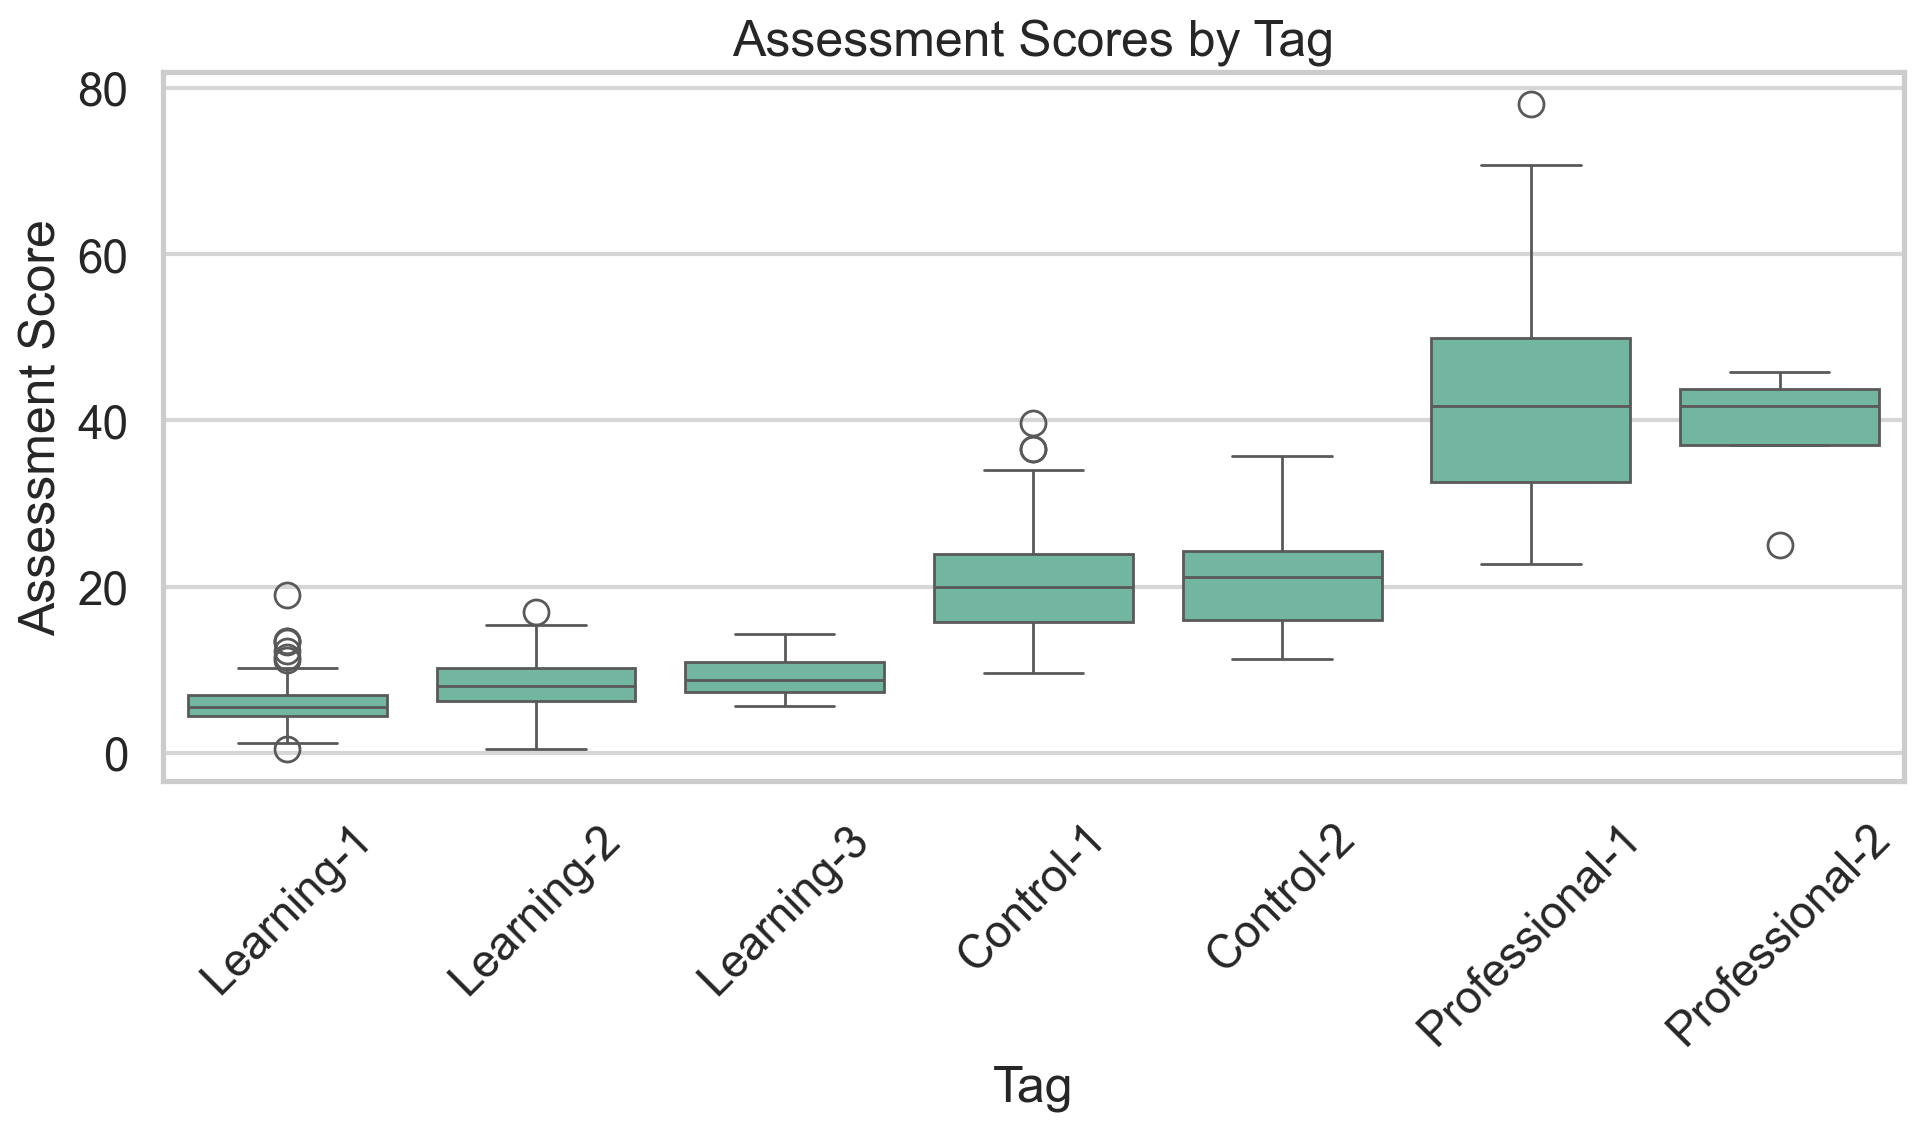

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# plt.style.use("seaborn-v0_8-whitegrid")

fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(
    data=df[df["tag"].str.contains("4") == False],
    x="tag",
    y="assessment_score",
    # hue="is_prock",
)
plt.xticks(rotation=45)
plt.title("Assessment Scores by Tag")
plt.xlabel("Tag")
plt.ylabel("Assessment Score")
plt.tight_layout()

In [71]:
import numpy as np
import pandas as pd
from statsmodels.formula.api import mixedlm
import statsmodels.formula.api as smf
from numpy.linalg import LinAlgError

# --------- CLEAN & PREP ---------
d = df.copy()

# 1) outcome must be numeric
d["assessment_score"] = pd.to_numeric(d["assessment_score"], errors="coerce")

# 2) define time and group binaries
#   If you have 'pre'/'post':
if d["session_number"].dtype == object:
    d["post"] = (d["session_number"].astype(str).str.lower() == "post").astype(int)
else:
    # numeric sessions: treat the earliest as pre, the latest as post
    # (if you already know 1=pre, 2=post, then simply: d["post"] = (d["session_number"] == 2).astype(int))
    d = d.sort_values(["subject_code", "session_number"])
    first = d.groupby("subject_code")["session_number"].transform("min")
    d["post"] = (d["session_number"] > first).astype(int)

#   Group: Learner vs Control
d["learner"] = (d["condition"].astype(str).str.lower().str.contains("learn")).astype(int)

# 3) keep only pre+post subjects and one row per timepoint
have_both = d.groupby("subject_code")["post"].transform(lambda s: 0 in set(s) and 1 in set(s))
d = d[have_both].copy()
d = (d.sort_values(["subject_code", "post", "age_at_scan", "session_number"])
       .drop_duplicates(["subject_code", "post"], keep="first"))

# 4) covariates
d["age_c"]  = d["age_at_scan"] - d["age_at_scan"].mean()
d["age_c2"] = d["age_c"]**2

# 5) drop any remaining NAs in model variables
model_cols = ["assessment_score", "post", "learner", "age_c", "age_c2", "subject_code"]
d = d.replace([np.inf, -np.inf], np.nan).dropna(subset=model_cols).copy()

# 6) reset index and build contiguous group codes ALIGNED with d
d = d.reset_index(drop=True)
group_codes = d["subject_code"].astype("category").cat.codes  # 0..G-1

# --------- FIT: MixedLM with random intercept ---------
formula = "assessment_score ~ post * learner + age_c + age_c2"
try:
    m = mixedlm(formula, data=d, groups=group_codes).fit(reml=True, method="lbfgs")
except (LinAlgError, ValueError) as e:
    # robust fallback (clustered SEs by subject)
    ols = smf.ols(formula, data=d).fit()
    m = ols.get_robustcov_results(cov_type="cluster", groups=d["subject_code"])
print(m.summary())

# The training (DiD) effect is the coefficient on post:learner
# For MixedLM:
term = "post:learner"
if term in getattr(m, "params", {}):
    est = m.params[term]
    se  = np.sqrt(np.diag(m.cov_params()))[list(m.params.index).index(term)]
    z   = est / se if se > 0 else np.nan
    from math import erf, sqrt
    p   = 2*(1 - 0.5*(1 + erf(abs(z)/sqrt(2)))) if np.isfinite(z) else np.nan
    print(f"DiD effect (post×learner): beta={est:.3f}, SE={se:.3f}, z={z:.2f}, p={p:.4f}")


            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: assessment_score
No. Observations: 306     Method:             REML            
No. Groups:       153     Scale:              8.0230          
Min. group size:  2       Log-Likelihood:     -855.4517       
Max. group size:  2       Converged:          Yes             
Mean group size:  2.0                                         
--------------------------------------------------------------
                 Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept        23.158    0.851  27.226 0.000  21.490  24.825
post              0.683    0.744   0.918 0.359  -0.775   2.141
learner         -17.573    0.898 -19.572 0.000 -19.333 -15.813
post:learner      1.739    0.826   2.105 0.035   0.120   3.358
age_c            -0.220    0.062  -3.548 0.000  -0.342  -0.099
age_c2            0.007    0.006   1.247 0.212  -0.004   0.018
Group

/tmp/ipykernel_2295017/325477266.py:39: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  d = d.replace([np.inf, -np.inf], np.nan).dropna(subset=model_cols).copy()
